# Data preparation and model selection


In [1]:
import numpy as np
import pandas as pd
import mlflow
import mlflow.sklearn
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from numpy import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor

import warnings
warnings.simplefilter("ignore")

In [2]:
X1 = pd.read_csv("data/X1.csv", index_col=0)
Y1 = pd.read_csv("data/Y1.csv", header=None, names=['Weight'])
X2 = pd.read_csv("data/X2.csv", index_col=0)

## Data preparation

### Data encoding

In [3]:
class DataEncoder(BaseEstimator):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        columns = ['Gender', 'Age', 'Height', 'Family history with overweight', 'Consumption of high caloric food',
           'Consumption frequency of vegetables', 'Number of main meals daily', 'Food Consumption between meals', 'Smoke',
           'Water consumption daily', 'Calories consumption monitoring', 'Physical activity frequency', 'Time using technology devices',
           'Alcohol consumption', 'Usual transportation used']
        X.columns = columns
        X['Consumption frequency of vegetables'] = X['Consumption frequency of vegetables'].replace(
            {1: '1. Never', 2: '2. Sometimes', 3: '3. Always'})
        X['Number of main meals daily'] = X['Number of main meals daily'].replace(
            {1: '1', 2: '2', 3: '3', 4: '3+'})
        X['Water consumption daily'] = X['Water consumption daily'].replace(
            {1: '1. Less than 1L', 2: '2. Between 1L and 2L', 3: '3. More than 2L'})
        X['Physical activity frequency'] = X['Physical activity frequency'].replace(
            {0: '1. I do not have', 1: '2. 1 or 2 days', 2: '3. 2 or 4 days', 3: '4. 4 or 5 days'})
        X['Time using technology devices'] = X['Time using technology devices'].replace(
            {0: '1. 0–2 hours', 1: '2. 3–5 hours', 2: '3. More than 5 hours'})
        X['Food Consumption between meals'] = X['Food Consumption between meals'].replace(
            {'no' : '1. No', 'Sometimes' : '2. Sometimes', 'Frequently': '3. Frequently','Always': '4. Always'})

        #X['Height'] = X['Height']*100

        X["Usual transportation used"] = X["Usual transportation used"].apply(lambda x : "Public_Transportation" if x == "Public_Transportation" else "Other")
        X["Public Transportation"] = X.apply(lambda x : "yes" if x['Usual transportation used'] == "Public_Transportation" else "no", axis=1)
        X.drop("Usual transportation used", inplace=True, axis=1)

        ordinal_cat = ['Consumption frequency of vegetables', 'Number of main meals daily', 'Food Consumption between meals',
               'Water consumption daily', 'Physical activity frequency', 'Time using technology devices',
               'Alcohol consumption']
        for cat in ordinal_cat:
            X[cat] = X[cat].map(lambda x: sorted(X[cat].unique()).index(x)+1)

        # Handling binary categorical features
        X[['Family history with overweight', 'Consumption of high caloric food', 'Smoke', 'Calories consumption monitoring','Public Transportation']] = X[[
            'Family history with overweight', 'Consumption of high caloric food', 'Smoke', 'Calories consumption monitoring','Public Transportation']].replace(to_replace=['no', 'yes'], value=[0, 1])
        X[['Gender']] = X[['Gender']].replace(
            to_replace=['Female', 'Male'], value=[0, 1])

        X.drop(["Smoke","Calories consumption monitoring"], inplace=True, axis=1)

        X['Age'] = X['Age'].map(lambda x: np.log(x))

        #X[ordinal_cat] = X[ordinal_cat].apply(lambda x : np.exp(x))

        return X.astype(np.float64),y

## Model selection

In [4]:
def score_weight_class(bmi_pred, bmi_true, low, high):
    tol = 1
    vpred = (bmi_pred >= low - tol) & (bmi_pred < high+tol)
    vtrue = (bmi_true >= low) & (bmi_true < high)
    if vtrue.sum() == 0:
        print("no true samples here")
        return 0
    rmse = np.sqrt(((bmi_true[vtrue]-bmi_pred[vtrue])**2).mean())
    rmse = rmse/(high-low+tol)  # normalize rmse in interval
    acc = (vpred & vtrue).sum()/vtrue.sum()
    return rmse*(1-acc)


def score_regression(ytrue, ypred, height):
    bmi_pred = ypred/(height*height)
    bmi_true = ytrue/(height*height)
    scores = []
    for bmi_low, bmi_high in zip([0, 18.5, 25, 30], [18.5, 25, 30, 100]):
        scores.append(score_weight_class(bmi_pred, bmi_true,
                                         low=bmi_low, high=bmi_high))
    return np.mean(scores)



In [16]:
X,y = DataEncoder().transform(X1.copy(),Y1.copy())
n_columns = len(X.columns)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

linear_models = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
}

non_linear_models = {
    # 'KNeighborsRegressor': KNeighborsRegressor(),
    # 'RandomForestRegressor' : RandomForestRegressor(),
    'MLPRegressor' : MLPRegressor()
}

linear_params = {
    'LinearRegression__fit_intercept': [True,False],

    'Lasso__alpha': random.uniform(low=0.0001, high=50, size=100),

    'Ridge__alpha': random.uniform(low=0.0001, high=50, size=100),
    'Ridge__solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],

}

non_linear_params = {
    # 'KNeighborsRegressor__weights': ['uniform', 'distance'],
    # 'KNeighborsRegressor__n_neighbors': random.randint(5, 200, size=100),
    # 'KNeighborsRegressor__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    # 'KNeighborsRegressor__leaf_size': random.randint(20, 200, size=100),

    # 'RandomForestRegressor__n_estimators': random.randint(1, 1000, size=100),
    # 'RandomForestRegressor__max_depth': random.randint(1, 1000, size=100),
    # 'RandomForestRegressor__max_features': ['sqrt', 'log2', 'auto'],
    # 'RandomForestRegressor__min_samples_split': random.randint(1, 1000, size=100),
    # 'RandomForestRegressor__min_samples_leaf': random.randint(1, 1000, size=100),
    # 'RandomForestRegressor__criterion' : ['squared_error', 'absolute_error', 'poisson'],
    
    'MLPRegressor__hidden_layer_sizes': list(zip(random.randint(10, 100, size=200),random.randint(10, 100, size=200))), 
    #'MLPRegressor__hidden_layer_sizes': random.randint(10, 200, size=100), 
    'MLPRegressor__solver': ['lbfgs', 'sgd', 'adam'],
    'MLPRegressor__learning_rate': ['constant', 'invscaling', 'adaptive'], 
    'MLPRegressor__alpha': random.uniform(low=0.001, high=200, size=200),
    'MLPRegressor__activation': ['logistic', 'tanh', 'relu', 'identity'],
    'MLPRegressor__max_iter': random.randint(100, 2000, size=200),
}

In [6]:
mlflow.set_experiment("Obsesity Regression")

<Experiment: artifact_location='file:///C:/Users/marci/Dropbox%20%28PCSAMU%20SRL%29/Documents/UCL%20-%20Master/Q3/LELEC2870%20-%20Machine%20learning%20%20regression%2C%20deep%20networks%20and%20dimensionality%20reduction/Project/mlruns/1', experiment_id='1', lifecycle_stage='active', name='Obsesity Regression', tags={}>

In [17]:
def run_randomized_search(models,params):
    for key in models.keys():
        with mlflow.start_run():
            print(f"Running RandomizedSearchCV for {key}.")
            model = models[key]
            param = {k : v for k,v in params.items() if key in k }
            pipeline = Pipeline(steps=[
                ('Scaler', StandardScaler()),
                (key,model)
            ])
            
            rs = RandomizedSearchCV(pipeline, param, n_iter=200, cv=KFold(n_splits=5), n_jobs=-2,
                                    verbose=8, scoring=['neg_mean_absolute_error','neg_root_mean_squared_error'], refit='neg_mean_absolute_error',
                                    random_state=42
                                    )
            
            rs.fit(X_train, y_train)
            mlflow.log_param("Best Estimator", key)
            mlflow.log_metric("score_train_mae", float(rs.best_score_))
            preds = rs.predict(X_test)
            mlflow.log_metric("score_test_mae", mean_absolute_error(preds,y_test))
            mlflow.log_metric("score_test_rmse", mean_squared_error(preds,y_test,squared=False))
            mlflow.log_metric("score_test_reg", score_regression(y_test['Weight'].ravel(),preds.ravel(),X_test['Height'].ravel()))
            
            for key in rs.best_params_:
                mlflow.log_param(key.split('__')[1], rs.best_params_[key])
            mlflow.sklearn.log_model(rs.best_estimator_, "best_model")


In [18]:
#Run Randomized Search for linear models
run_randomized_search(linear_models,linear_params)


Running RandomizedSearchCV for LinearRegression.
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Running RandomizedSearchCV for Lasso.
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Running RandomizedSearchCV for Ridge.
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [ ]:

#Run Randomized Search for non-linear models
run_randomized_search(non_linear_models,non_linear_params)

In [19]:
#Getting the best experients from Mlflow
df_experients = mlflow.search_runs(filter_string="metrics.score_test_reg < 0.12")

#Getting the best run id
best_experients_run_id = df_experients.loc[df_experients['metrics.score_test_reg'].idxmin()]['run_id']
best_experients_reg_score = df_experients.loc[df_experients['metrics.score_test_reg'].idxmin()]['metrics.score_test_reg']
#Load model
model = mlflow.sklearn.load_model("runs:/" + best_experients_run_id + "/best_model")
print(model)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('MLPRegressor',
                 MLPRegressor(activation='identity', alpha=43.878636243378956,
                              hidden_layer_sizes=(15, 11),
                              learning_rate='invscaling', max_iter=533))])


In [ ]:
#Predict Y2
X,_ = DataEncoder().transform(X2.copy())
y_pred = model.predict(X)
series_y = pd.Series(y_pred)
series_y = series_y.append(pd.Series(best_experients_reg_score))
series_y.to_csv('data/Y2.csv',index=False,header=False,sep='\n')


## Classification


### Getting the labels

In [20]:
def get_label(height, weight):
    bmi = weight/height**2
    if 0 < bmi < 18.5:
        return 'underweight'
    if 18.5 < bmi < 25.0:
        return 'normal'
    if 25.0 < bmi < 30.0:
        return 'overweight'
    if bmi >=30.0:
        return 'obese'

y_pred = model.predict(X_test)
df_true = pd.concat([X_test,y_test], axis=1)
df_pred = pd.concat([X_test,pd.DataFrame(y_pred, columns=['Weight'], index=X_test.index)], axis=1)
true_labels = df_true.apply(lambda x : get_label(x['Height'],x['Weight']),axis=1).ravel()
pred_labels = df_pred.apply(lambda x : get_label(x['Height'],x['Weight']),axis=1).ravel()

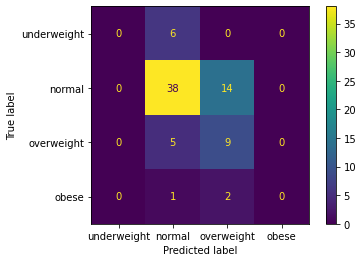

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, labels=['underweight','normal','overweight','obese'])

In [22]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

      normal       0.76      0.73      0.75        52
       obese       0.00      0.00      0.00         3
  overweight       0.36      0.64      0.46        14
 underweight       0.00      0.00      0.00         6

    accuracy                           0.63        75
   macro avg       0.28      0.34      0.30        75
weighted avg       0.59      0.63      0.60        75



## Conclusion